# Understanding Modularity in Network Community Detection

This notebook provides an in-depth exploration of modularity, a key metric used in community detection algorithms for complex networks. We'll cover the theoretical foundations, mathematical formulations, implementations in NetworkX, and practical examples using real-world networks including the famous Zachary's Karate Club network.

## Learning Objectives

By the end of this notebook, you will understand:
- What modularity is and why it's important for community detection
- How to mathematically calculate modularity
- Different formulations of modularity for various types of networks
- The limitations of modularity (resolution limit, degeneracy, etc.)
- How to implement modularity calculations using NetworkX
- How to interpret modularity scores in real network analysis

## 1. Setting Up Our Environment

First, let's import the necessary libraries for our analysis:

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import random
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Modularity: Theoretical Foundation

### 2.1 What is Modularity?

**Modularity** is a measure of the quality of a network partition into communities. It quantifies the difference between:
- The actual density of connections within communities
- The expected density if connections were distributed randomly while maintaining the same degree distribution

The core idea is to compare the real network structure against a null model where community structure is absent but other structural properties (like degree distribution) are preserved.

### 2.2 Mathematical Definition

For an undirected, unweighted network, modularity (Q) is defined as:

$$Q = \frac{1}{2m}\sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

Where:
- $A_{ij}$ is the adjacency matrix element (1 if nodes $i,j$ are connected, 0 otherwise)
- $k_i, k_j$ are the degrees of nodes $i$ and $j$
- $m$ is the total number of edges in the network
- $\delta(c_i, c_j)$ is 1 if nodes $i$ and $j$ belong to the same community, 0 otherwise
- $\frac{k_i k_j}{2m}$ is the expected number of edges between nodes $i$ and $j$ in the null model (Configuration Model)

### 2.3 Community-Based Formulation

We can rewrite the modularity formula in terms of communities:

$$Q = \sum_{C} \left[ \frac{L_C}{m} - \left(\frac{k_C}{2m}\right)^2 \right]$$

Where:
- $L_C$ is the number of links within community $C$
- $k_C$ is the sum of the degrees of all nodes in community $C$
- $m$ is the total number of links in the network

This can also be expressed as:

$$Q = \frac{1}{m}\sum_C \left( L_C - \frac{k^2_C}{4m} \right)$$

### 2.4 Understanding the Null Model

The term $\frac{k_i k_j}{2m}$ in the modularity equation represents the probability of an edge existing between nodes $i$ and $j$ in a **random network** that:
1. Has the same number of nodes as the original network
2. Preserves the degree sequence of the original network (each node maintains its degree)
3. Places edges randomly with this constraint

This is the **Configuration Model**, a random graph model where:
- Each node has the same number of "stubs" (half-edges) as its degree in the original network
- Stubs are paired randomly to form complete edges

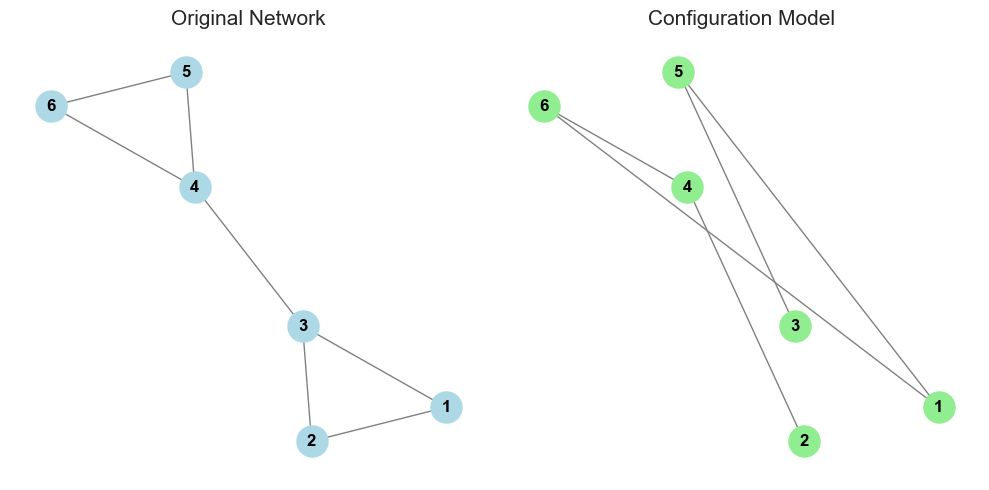

Nodes 1-2: Actual=1, Expected=0.2857
Nodes 1-3: Actual=1, Expected=0.4286
Nodes 1-4: Actual=0, Expected=0.4286
Nodes 1-5: Actual=0, Expected=0.2857
Nodes 1-6: Actual=0, Expected=0.2857
Nodes 2-3: Actual=1, Expected=0.4286
Nodes 2-4: Actual=0, Expected=0.4286
Nodes 2-5: Actual=0, Expected=0.2857
Nodes 2-6: Actual=0, Expected=0.2857
Nodes 3-4: Actual=1, Expected=0.6429
Nodes 3-5: Actual=0, Expected=0.4286
Nodes 3-6: Actual=0, Expected=0.4286
Nodes 4-5: Actual=1, Expected=0.4286
Nodes 4-6: Actual=1, Expected=0.4286
Nodes 5-6: Actual=1, Expected=0.2857


In [23]:
# Let's illustrate the configuration model with a small example
def create_small_network():
    G = nx.Graph()
    G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)])
    return G

G_small = create_small_network()

# Visualize the original network
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G_small, seed=42)
nx.draw(G_small, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_weight='bold', edge_color='gray')
plt.title("Original Network", fontsize=15)

# Create a configuration model version
degrees = [d for n, d in G_small.degree()]
G_config = nx.configuration_model(degrees, seed=42)
G_config = nx.Graph(G_config)  # Remove parallel edges
G_config.remove_edges_from(nx.selfloop_edges(G_config))  # Remove self-loops

# Relabel nodes to match original network
mapping = {i: list(G_small.nodes())[i] for i in range(len(G_small))}
G_config = nx.relabel_nodes(G_config, mapping)

# Visualize the configuration model
plt.subplot(1, 2, 2)
nx.draw(G_config, pos, with_labels=True, node_color='lightgreen', 
        node_size=500, font_weight='bold', edge_color='gray')
plt.title("Configuration Model", fontsize=15)

plt.tight_layout()
plt.show()

# Calculate the expected number of edges between nodes in the configuration model
m = G_small.number_of_edges()
for i in G_small.nodes():
    for j in G_small.nodes():
        if i < j:  # Avoid counting twice for undirected graph
            ki = G_small.degree(i)
            kj = G_small.degree(j)
            expected = (ki * kj) / (2 * m)
            actual = 1 if G_small.has_edge(i, j) else 0
            print(f"Nodes {i}-{j}: Actual={actual}, Expected={expected:.4f}")

### 2.5 Interpreting Modularity Values

- **Q = 0**: The community structure is no better than random
- **Q < 0**: The community structure is worse than random (communities are less densely connected internally than would be expected by chance)
- **Q > 0**: The network has more connections within communities than would be expected in a random network
- **Q ≈ 0.3-0.7**: Typical range for networks with strong community structure
- **Q < 1**: Theoretical upper bound (practically never reached)

Modularity is always calculated with respect to a specific partition of the network into communities.

## 3. Implementing Modularity Calculation From Scratch

To deepen our understanding, let's implement modularity calculation from first principles before using NetworkX's built-in functions.

In [24]:
def calculate_modularity_from_scratch(G, communities):
    """
    Calculate modularity of a given partition of the network
    
    Parameters:
    -----------
    G : networkx.Graph
        The input network
    communities : list of sets
        Each set contains the nodes in one community
        
    Returns:
    --------
    float
        The modularity value
    """
    # Create a dictionary mapping each node to its community
    node_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_community[node] = i
    
    m = G.number_of_edges()
    
    # Initialize modularity
    Q = 0
    
    # For each pair of nodes
    for i in G.nodes():
        for j in G.nodes():
            # Check if they're in the same community
            if node_community.get(i) == node_community.get(j):
                # Check if there's an edge
                if G.has_edge(i, j):
                    actual = 1
                else:
                    actual = 0
                
                # Calculate expected number of edges in configuration model
                ki = G.degree(i)
                kj = G.degree(j)
                expected = (ki * kj) / (2 * m)
                
                # Add contribution to modularity
                Q += (actual - expected)
    
    # Normalize by 2m (each edge is counted twice in undirected graphs)
    Q /= (2 * m)
    
    return Q

In [25]:
# Let's also implement the alternative community-based formulation
def calculate_modularity_community_based(G, communities):
    """
    Calculate modularity using the community-based formulation
    
    Parameters:
    -----------
    G : networkx.Graph
        The input network
    communities : list of sets
        Each set contains the nodes in one community
        
    Returns:
    --------
    float
        The modularity value
    """
    m = G.number_of_edges()
    Q = 0
    
    # For each community
    for community in communities:
        # Count internal links
        L_C = G.subgraph(community).number_of_edges()
        
        # Calculate total degree of nodes in the community
        k_C = sum(G.degree(node) for node in community)
        
        # Add this community's contribution to modularity
        Q += (L_C/m - (k_C/(2*m))**2)
    
    return Q

## 5. Modularity Extensions

The standard modularity definition applies to undirected, unweighted networks. However, there are extensions for other types of networks:

### 5.1 Directed Networks

For directed networks, modularity becomes:

$$Q_d = \frac{1}{m}\sum_C \left( L_C - \frac{k^{in}_C k^{out}_C}{m} \right)$$

Where:
- $L_C$ is the number of internal links in community $C$
- $k^{in}_C$ is the total in-degree of nodes in community $C$
- $k^{out}_C$ is the total out-degree of nodes in community $C$

### 5.2 Weighted Networks

For weighted networks, we replace degree with strength (sum of weights) and count the weight of edges rather than their number:

$$Q_w = \frac{1}{W}\sum_C \left( W_C - \frac{s^2_C}{4W} \right)$$

Where:
- $W$ is the total weight of network links
- $W_C$ is the total weight of internal links in community $C$
- $s_C$ is the total strength of nodes in community $C$

Let's demonstrate modularity calculation on weighted networks:

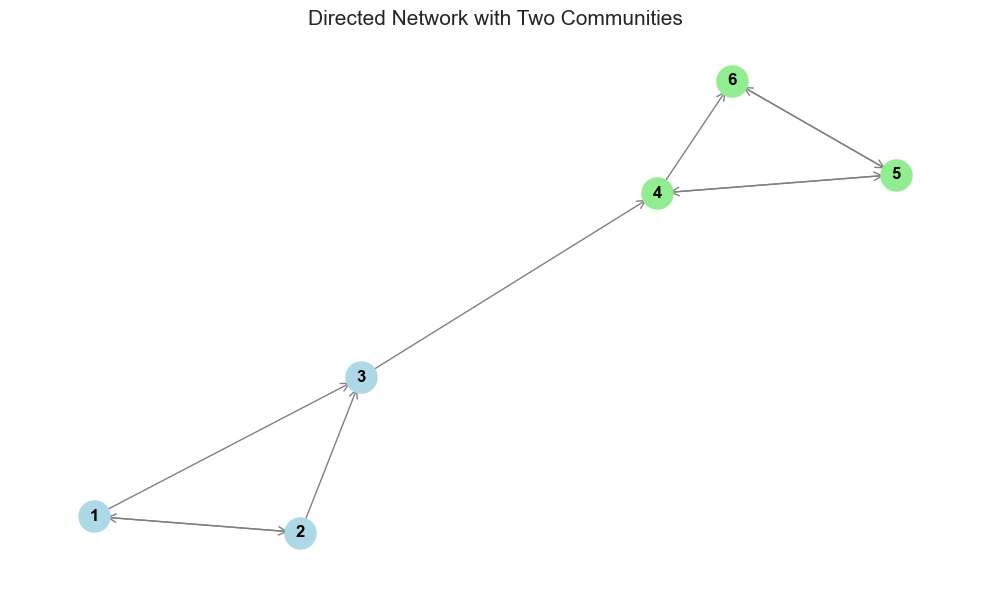

Modularity of directed network: 0.4000
NetworkX modularity: 0.4000
Our implementation matches NetworkX!

Detailed calculation:
Community 1 ({1, 2, 3}):
  Internal links: 4
  Total in-degree: 4
  Total out-degree: 5
  Expected fraction of links: 0.4082
  Contribution to modularity: 0.1633
Community 2 ({4, 5, 6}):
  Internal links: 5
  Total in-degree: 6
  Total out-degree: 5
  Expected fraction of links: 0.6122
  Contribution to modularity: 0.1020


In [26]:
from networkx.algorithms.community import modularity

# Example of modularity calculation in a directed network
def calculate_modularity_directed(G, communities):
    """
    Calculate modularity for a directed network
    
    Parameters:
    -----------
    G : networkx.DiGraph
        The input directed network
    communities : list of sets
        Each set contains the nodes in one community
        
    Returns:
    --------
    float
        The modularity value
    """
    m = G.number_of_edges()
    Q = 0
    
    # For each community
    for community in communities:
        # Count internal links
        L_C = G.subgraph(community).number_of_edges()
        
        # Calculate total in-degree and out-degree of nodes in the community
        k_in_C = sum(G.in_degree(node) for node in community)
        k_out_C = sum(G.out_degree(node) for node in community)
        
        # Add this community's contribution to modularity
        Q += (L_C/m - (k_in_C * k_out_C)/(m**2))
    
    return Q

# Create a small directed network
G_directed = nx.DiGraph()
G_directed.add_edges_from([
    (1, 2), (1, 3), (2, 1), (2, 3), (3, 4),
    (4, 5), (4, 6), (5, 4), (5, 6), (6, 5)
])

# Define two communities
communities = [{1, 2, 3}, {4, 5, 6}]

# Visualize the directed network with communities
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_directed, seed=42)

# Draw nodes with different colors for each community
colors = ['lightblue', 'lightgreen']
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G_directed, pos, 
                           nodelist=list(community),
                           node_color=colors[i], 
                           node_size=500)

# Draw edges with arrows
nx.draw_networkx_edges(G_directed, pos, edge_color='gray', 
                       arrowstyle='->', arrowsize=15)

# Draw labels
nx.draw_networkx_labels(G_directed, pos, font_weight='bold')

plt.title("Directed Network with Two Communities", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

# Calculate modularity from scratch
Q_directed = calculate_modularity_directed(G_directed, communities)
print(f"Modularity of directed network: {Q_directed:.4f}")

# Compare with NetworkX's implementation (if available)
try:
    
    # Create a partition dictionary for NetworkX
    partition = {}
    for i, community in enumerate(communities):
        for node in community:
            partition[node] = i
    
    Q_nx = modularity(G_directed, [set(c) for c in communities])
    print(f"NetworkX modularity: {Q_nx:.4f}")
    
    if abs(Q_directed - Q_nx) < 0.01:
        print("Our implementation matches NetworkX!")
    else:
        print("Note: NetworkX uses a different formula for directed networks")
except:
    print("NetworkX modularity function not available for directed graphs")

# Show details of the calculation
print("\nDetailed calculation:")
for i, community in enumerate(communities):
    L_C = G_directed.subgraph(community).number_of_edges()
    k_in_C = sum(G_directed.in_degree(node) for node in community)
    k_out_C = sum(G_directed.out_degree(node) for node in community)
    expected = (k_in_C * k_out_C) / (m**2)
    contribution = (L_C/m - expected)
    
    print(f"Community {i+1} ({community}):")
    print(f"  Internal links: {L_C}")
    print(f"  Total in-degree: {k_in_C}")
    print(f"  Total out-degree: {k_out_C}")
    print(f"  Expected fraction of links: {expected:.4f}")
    print(f"  Contribution to modularity: {contribution:.4f}")

## 6. Modularity Limitations

Despite its popularity, modularity has several important limitations:

### 6.1 Resolution Limit

One of the most significant limitations of modularity is the **resolution limit**. Modularity optimization cannot detect communities smaller than a certain scale, which depends on the total size of the network.

Specifically, communities with fewer than ~$\sqrt{2E}$ edges (where $E$ is the total number of edges in the network) tend to be merged together, even if they are well-defined communities.

### 6.2 Degeneracy

Another limitation of modularity is **degeneracy** - the existence of multiple different partitions with similar modularity values. This means that small perturbations in the network or the algorithm can lead to substantially different community assignments.

### 6.3 Other Limitations

1. **Lack of a universal threshold**: There's no universal threshold for a "good" modularity value. A value of 0.3 might be significant in one network but not in another.

2. **Random networks can have high modularity**: Even random graphs without actual community structure can yield partitions with relatively high modularity values.

3. **Local optimization trap**: Most modularity optimization algorithms are greedy and can get stuck in local optima.

4. **Scaling with network size**: Modularity tends to scale with network size, making it difficult to compare modularity values across networks of different sizes.

## 7. Resolution Parameter

To address the resolution limit problem, some modularity optimization methods include a resolution parameter that can be adjusted:

$$Q_\gamma = \frac{1}{2m}\sum_{i,j} \left[ A_{ij} - \gamma \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

Where $\gamma$ is the resolution parameter:
- $\gamma > 1$ yields smaller communities (higher resolution)
- $\gamma < 1$ yields larger communities (lower resolution)

Let's see how different resolution values affect community detection:

In [27]:
# Explore different resolution parameters with Louvain
resolution_values = [0.5, 1.0, 2.0, 5.0]
results = []

for resolution in resolution_values:
    partition = community_louvain.best_partition(karate, resolution=resolution)
    
    # Convert to a list of sets format
    communities = []
    for com in set(partition.values()):
        comm = {node for node, community in partition.items() if community == com}
        communities.append(comm)
    
    # Calculate regular modularity (without resolution parameter)
    mod = modularity(karate, communities)
    
    results.append({
        'resolution': resolution,
        'num_communities': len(communities),
        'modularity': mod,
        'partition': partition,
        'communities': communities
    })
    
    print(f"Resolution {resolution}: Found {len(communities)} communities with modularity {mod:.4f}")

# Visualize the effect of resolution parameter
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, result in enumerate(results):
    res = result['resolution']
    colors = [cm.rainbow(j/len(result['communities'])) for j in result['partition'].values()]
    
    nx.draw_networkx(karate, pos, node_color=colors, node_size=500, with_labels=True, 
                    font_size=10, font_weight='bold', ax=axes[i])
    axes[i].set_title(f"Resolution = {res} ({result['num_communities']} communities)\nModularity = {result['modularity']:.4f}", 
                     fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plot how the number of communities changes with resolution
resolutions = np.linspace(0.1, 10, 50)
community_counts = []

for res in resolutions:
    partition = community_louvain.best_partition(karate, resolution=res)
    community_counts.append(len(set(partition.values())))

plt.figure(figsize=(10, 6))
plt.plot(resolutions, community_counts, 'o-', linewidth=2)
plt.xlabel('Resolution Parameter', fontsize=14)
plt.ylabel('Number of Communities', fontsize=14)
plt.title('Effect of Resolution Parameter on Community Count', fontsize=16)
plt.grid(True)
plt.show()

NameError: name 'community_louvain' is not defined

## 8. Practical Recommendations

Based on our exploration, here are some practical recommendations for using modularity in community detection:

1. **Use multiple algorithms**: Compare results from different algorithms (e.g., Louvain, Girvan-Newman, label propagation) to get a more robust perspective.

2. **Run multiple times**: Due to the degeneracy issue, run stochastic algorithms multiple times and examine the distribution of results.

3. **Explore different resolutions**: If available, try different resolution parameters to see communities at different scales.

4. **Verify with domain knowledge**: Use domain knowledge to validate whether the detected communities make sense.

5. **Consider alternative quality metrics**: In addition to modularity, consider other metrics like conductance, coverage, or performance.

6. **Visualize results**: Visualize the network with community assignments to get an intuitive understanding of the partition.

7. **Compare with null models**: Compare modularity values with those obtained from appropriate null models to assess significance.

## 9. Summary

In this notebook, we've explored modularity in depth:

- **What modularity is**: A quality function that measures how well a network is partitioned into communities by comparing the actual structure to a random null model

- **Mathematical formulations**: We examined different ways to calculate modularity for various types of networks

- **Implementation**: We implemented modularity calculation from scratch and used NetworkX's built-in functions

- **Limitations**: We demonstrated key limitations including resolution limit, degeneracy, and issues with random networks

- **Practical usage**: We provided practical recommendations for using modularity in real-world network analysis

Modularity remains one of the most popular quality functions for community detection despite its limitations. Understanding its strengths and weaknesses is crucial for properly interpreting the results of community detection algorithms.

## 10. References

1. Newman, M. E. J. & Girvan, M. (2004). Finding and evaluating community structure in networks. Physical Review E, 69(2), 026113.

2. Clauset, A., Newman, M. E. J., & Moore, C. (2004). Finding community structure in very large networks. Physical Review E, 70(6), 066111.

3. Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008(10), P10008.

4. Fortunato, S., & Barthélemy, M. (2007). Resolution limit in community detection. Proceedings of the National Academy of Sciences, 104(1), 36-41.

5. Newman, M. E. J. (2006). Modularity and community structure in networks. Proceedings of the National Academy of Sciences, 103(23), 8577-8582.

6. Fortunato, S. (2010). Community detection in graphs. Physics Reports, 486(3-5), 75-174.